In [1]:
import numpy as np
import xml.etree.ElementTree as ET
import os
import pandas as pd
import json
import scipy.stats
from utils import create_til_score
from multiprocessing import Pool
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from utils import is_l1
from tiatoolbox.wsicore.wsireader import VirtualWSIReader
import numpy as np
from tiatoolbox.wsicore.wsireader import VirtualWSIReader, WSIReader
import os
import matplotlib.pyplot as plt
import cv2
from utils import mm2_to_px, dist_to_px
import skimage
from scipy.spatial import Delaunay
from shapely.ops import polygonize, unary_union
import math
import shapely.geometry as geometry
import shapely
from PIL import Image, ImageDraw

In [2]:
ground_truth = pd.read_csv(
    "/home/u1910100/Documents/Tiger_Data/wsitils/tiger-til-scores-wsitils.csv"
)
# print(ground_truth['image-id'], ground_truth['tils-score'])

gt_til_score_dict = {}

for i, row in ground_truth.iterrows():
    id = row["image-id"]
    score = row["tils-score"]
    gt_til_score_dict[id] = score

print(gt_til_score_dict)

with open("ground_truth_tils.json", "w") as file:
    json.dump(gt_til_score_dict, file)

{'104S': 70, '105S': 10, '106S': 10, '107S': 5, '108S': 30, '110S': 1, '112B': 1, '121S': 5, '123S': 60, '126B': 10, '129S': 40, '132B': 1, '139B': 40, '146B': 1, '155B': 3, '159S': 1, '160B': 75, '161S': 20, '162S': 50, '165B': 1, '174S': 85, '175B': 20, '184B': 5, '205B': 1, '208B': 1, '211B': 20, '212B': 5, '214B': 1, '223B': 1, '224B': 40, '227S': 95, '228B': 20, '233B': 1, '236B': 70, '244B': 1, '247B': 10, '248B': 10, 'TC_S01_P000004_C0001_B103': 95, 'TC_S01_P000006_C0001_B206': 90, 'TC_S01_P000020_C0001_B207': 5, 'TC_S01_P000041_C0001_B101': 5, 'TC_S01_P000045_C0001_B106': 20, 'TC_S01_P000047_C0001_B101': 1, 'TC_S01_P000049_C0001_B101': 3, 'TC_S01_P000052_C0001_B101': 95, 'TC_S01_P000055_C0001_B101': 65, 'TC_S01_P000058_C0001_B101': 1, 'TC_S01_P000061_C0001_B101': 65, 'TC_S01_P000063_C0001_B101': 5, 'TC_S01_P000064_C0001_B101': 1, 'TC_S01_P000073_C0001_B101': 30, 'TC_S01_P000074_C0001_B101': 5, 'TC_S01_P000077_C0001_B101': 10, 'TC_S01_P000079_C0001_B101': 15, 'TC_S01_P000083_C00

In [ ]:
wsi_name = "104S.tif"
wsi_without_ext = os.path.splitext(wsi_name)[0]
cell_points_dir = "/home/u1910100/GitHub/TIAger-Torch/output/det_out"
cell_points_path = os.path.join(cell_points_dir, f"{wsi_without_ext}_points.json")
wsi_dir = "/home/u1910100/Documents/Tiger_Data/wsitils/images/"
wsi_path = os.path.join(wsi_dir, wsi_name)
xml_path = "/home/u1910100/GitHub/TIAger-Torch/xml/105S.xml"
bulk_path = "/home/u1910100/GitHub/TIAger-Torch/tf_seg_out/tempout/105S_bulk.npy"
create_til_score(wsi_path, xml_path, bulk_path)

In [ ]:
xml_dir = "/home/u1910100/GitHub/TIAger-Torch/xml"
tf_til_score_dict = {}
wsi_dir = "/home/u1910100/Documents/Tiger_Data/wsitils/images/"


for xml_file in tqdm(os.listdir(xml_dir)):
    xml_path = os.path.join(xml_dir, xml_file)
    slide_name = os.path.splitext(xml_file)[0]
    print(slide_name)
    mask_path = f"output/temp_out/{slide_name}.npy"
    tissue_mask = np.load(mask_path)
    tumor_stroma_mask_path = f"/home/u1910100/GitHub/TIAger-Torch/tf_seg_out/tempout/{slide_name}_bulk_stroma.npy"
    if is_l1(tissue_mask):
        print("l1")
        mask_reader = VirtualWSIReader.open(tissue_mask, mpp=8, power=1.25, mode="bool")
        mask = mask_reader.slide_thumbnail(resolution=32, units="mpp")[:, :, 0]
    else:
        if not os.path.exists(tumor_stroma_mask_path):
            continue
        mask = np.load(tumor_stroma_mask_path)

    wsi_path = os.path.join(wsi_dir, f"{slide_name}.tif")
    score = create_til_score(wsi_path, xml_path, mask)

    tf_til_score_dict[slide_name] = score

print(tf_til_score_dict)

with open("tf_tils.json", "w") as file:
    json.dump(tf_til_score_dict, file)

In [ ]:
with open("tf_tils.json", "r") as file:
    tf_til_score_dict = json.load(file)
print(len(tf_til_score_dict))

tf_pred_tils = []
true_tils = []
for slide_id in tf_til_score_dict.keys():
    tf_pred_tils.append(tf_til_score_dict[slide_id])
    true_tils.append(gt_til_score_dict[slide_id])

print(scipy.stats.pearsonr(true_tils, tf_pred_tils))
print(scipy.stats.spearmanr(true_tils, tf_pred_tils))

plt.scatter(tf_pred_tils, true_tils)
plt.xlabel("TF Predicted TILs")
plt.ylabel("Ground Truth")
plt.show()

PearsonRResult(statistic=0.7943689707561445, pvalue=5.320919442756478e-19)
SignificanceResult(statistic=0.7036384952337212, pvalue=1.676529366498127e-13)


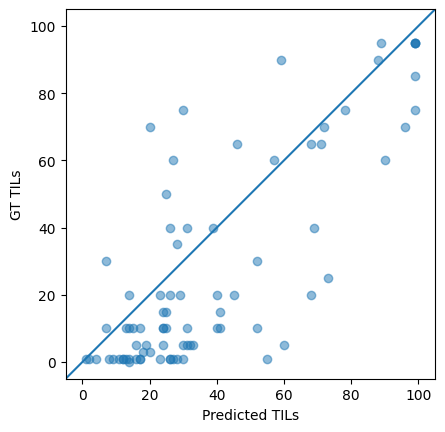

In [4]:
til_score_dir = "output/tils_v2"
pred_tils = []
tf_tils = []
gt_tils = []
for score_file in os.listdir(til_score_dir):
    slide_id = os.path.splitext(score_file)[0]

    file = open(os.path.join(til_score_dir, score_file), "r")
    score = file.read()
    file.close()

    # if tf_til_score_dict.get(slide_id) is not None:
    pred_tils.append(int(score))
    gt_tils.append(gt_til_score_dict[slide_id])
    # tf_tils.append(tf_til_score_dict[slide_id])

    # print(f"{slide_id}, torch_pred={score}, gt={gt_til_score_dict[slide_id]}")

print(scipy.stats.pearsonr(pred_tils, gt_tils))
print(scipy.stats.spearmanr(pred_tils, gt_tils))
# plt.scatter(pred_tils, gt_tils, alpha=0.5)
plt.scatter(pred_tils, gt_tils, alpha=0.5)
plt.xlim(-5, 105)
plt.ylim(-5, 105)
ax = plt.gca()
ax.set_aspect("equal", adjustable="box")
# plt.scatter(pred_tils, tf_tils)
plt.axline((0, 0), (100, 100))
plt.xlabel("Predicted TILs")
plt.ylabel("GT TILs")
plt.show()

In [21]:
dist_to_px(2.3, 0.5)

5